***Please Note that, I used the link of the dataset in this Notebook and didn't attach it in a file while submission because Moodle didn't allow me to upload it since it is a huge dataset. Thank you ***

***Week 4 - NLP - Assignment: Machine Translation: A Comparative Experiment***

Questions:

1- Select two tools for MT (some are listed already in the slides)

2- Select a corpus dedicated for MT (some are also listed in the slides)

3- Apply translation using each of the tools,

Evaluate the results using BLEU score.

4- Compare between the results, include a graphical comparison (using matplotlib, for example)

5- Comment on the results, explain the difference if any and the reason one tool performed better than the other in your opinion.

You can always build your own translation model if you have corpus for that purpose.

Make sure to include comments in your code and to explain what’s happening in each cell otherwise the activity will be penalized.

***Step 1 - Download and Prepare the Dataset***



In [1]:
#download and prepare the Dataset
#imports
import requests
import gzip
import xml.etree.ElementTree as ET
import gc

#define the url and file name
dataset_url = "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/tmx/ar-en.tmx.gz"
file_name = "ar-en.tmx.gz"

#download the dataset
def download_dataset(url, file_name):
    response = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(response.content)
    print(f"Dataset downloaded and saved as {file_name}")
    del response  #free memory after downloading
    gc.collect()

download_dataset(dataset_url, file_name)

Dataset downloaded and saved as ar-en.tmx.gz


The OPUS OpenSubtitles 2018 Arabic-English parallel corpus, which includes sentence pairs in both Arabic and English, was downloaded in this step.

Because it offers real-world translations that can be compared with translations created by machines, this dataset is helpful for assessing machine translation technologies.


***Step 2 - Load the Corpus in Batches***

In [2]:
#define the XML namespace for TMX files
namespaces = {'xml': 'http://www.w3.org/XML/1998/namespace'}

#load the corpus in batches
def load_corpus_in_batches(file_path, batch_size=100):
    with gzip.open(file_path, 'rb') as f:
        tree = ET.iterparse(f, events=('start', 'end'))
        translations = []
        count = 0
        for event, elem in tree:
            if event == 'end' and elem.tag == 'tu':
                #find Arabic and English translations using the namespace
                arabic_text = elem.find('tuv[@xml:lang="ar"]/seg', namespaces).text
                english_text = elem.find('tuv[@xml:lang="en"]/seg', namespaces).text
                translations.append((arabic_text, english_text))

                #process in batches
                count += 1
                if count % batch_size == 0:
                    yield translations
                    translations = []  #clear the batch for next batch

                elem.clear()  #clear memory

        #yield any remaining translations
        if translations:
            yield translations
        del tree, elem  #free memory
        gc.collect()

#process the batches
for batch in load_corpus_in_batches(file_name, batch_size=100):
    print(f"Processing batch of {len(batch)} sentences.")
    break


Processing batch of 100 sentences.


The OPUS OpenSubtitles 2018 dataset was parsed in this step, and the sentence pairings were loaded in manageable batches.

This avoids loading the whole dataset, especially for large datasets all at once into memory, which could lead to performance problems.

***Step 3 - Select two MT Tools***

We chose two machine translation tools: the popular general-purpose translator Google Translate and the neural machine translation (NMT) model OPUS-MT. Both tools have the ability to translate from Arabic to English.

1- Google Translate: A popular all-purpose translation application that translates between several languages using neural networks.

2- OPUS-MT: A neural machine translation (NMT) model trained on big parallel corpora and intended for high-quality translations.



In [3]:
pip install googletrans==4.0.0-rc1

In [4]:
#step 3.1 - Google Translate
from googletrans import Translator

#function to perform translation using Google Translate
def google_translate(text, source_lang='ar', target_lang='en'):
    translator = Translator()
    result = translator.translate(text, src=source_lang, dest=target_lang)
    return result.text

#process translations with Google Translate
def process_google_translate_batch(batch):
    for arabic_sentence, english_reference in batch:
        google_translation = google_translate(arabic_sentence)
        print(f"Google Translate Translation: {google_translation}")
        print(f"Reference: {english_reference}")
    del batch  #free memory after processing batch
    gc.collect()

#lets take an example - run Google Translate for the first batch
for batch in load_corpus_in_batches(file_name, batch_size=5):
    process_google_translate_batch(batch)
    break


Google Translate Translation: The weather is the last thing that really is on the ground.
Reference: The weather is the last truly wild thing on Earth.
Google Translate Translation: We cannot signs it and we cannot surround it.
Reference: We can't predict it and we can't control it.
Google Translate Translation: I am Donal McClentire, and I will travel around the world to search for the most brutal weather there.
Reference: I'm Donal Maclntyre, and I'm going to journey around the world to seek out the wildest weather there is.
Google Translate Translation: In this series, I will face the fastest wind on Earth.
Reference: In this series, I'm going to experience the fastest winds on Earth.
Google Translate Translation: One hundred and thirty -six miles per hour.
Reference: 136 miles an hour.


Observations:

1- Google Translate Translation: "The weather is the last thing that really is on the ground".

Reference: "The weather is the last truly wild thing on Earth".

Comment: Although the translation accurately conveys the meaning, it slightly mistranslates "wild thing" as "thing on the ground".

2- Google Translate Translation: "We cannot signs it and we cannot surround it".

Reference: "We can't predict it and we can't control it".

Comment: For "predict" and "control", the translation is wrong, but the phrase structure is still valid.

3- Google Translate Translation: "I am Donal McClentire, and I will travel around the world to search for the most brutal weather there".

Reference: "I'm Donal Maclntyre, and I'm going to journey around the world to seek out the wildest weather there is".

Comment: "Brutal weather" is not exactly the same as "wildest weather", but it is rather close. The translation affected the name somewhat.

4- Google Translate Translation: "In this series, I will face the fastest wind on Earth".

Reference: "In this series, I'm going to experience the fastest winds on Earth".

Comment: This is a good translation; the wording is a little different, but the overall point is the same.

5- Google Translate Translation: "One hundred and thirty-six miles per hour".

Reference: "136 miles an hour".

Comment: This is a perfect translation.

In [5]:
#Step 3.2 - Translation Using OPUS-MT
from transformers import MarianMTModel, MarianTokenizer
import gc

#load OPUS-MT model for Arabic to English translation
model_name = 'Helsinki-NLP/opus-mt-ar-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

#function to perform OPUS-MT translation
def opus_mt_translate(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    translated = model.generate(**inputs)
    translated_text = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    return translated_text[0]

#process OPUS-MT translations for a batch
def process_opus_mt_batch(batch):
    for arabic_sentence, english_reference in batch:
        opus_mt_translation = opus_mt_translate(arabic_sentence)
        print(f"OPUS-MT Translation: {opus_mt_translation}")
        print(f"Reference: {english_reference}")
    del batch  #free memory after processing batch
    gc.collect()

#lets take an example - run OPUS-MT translations for the first batch
for batch in load_corpus_in_batches(file_name, batch_size=5):
    process_opus_mt_batch(batch)
    break


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default.

OPUS-MT Translation: The weather is the last thing that's really wild on Earth.
Reference: The weather is the last truly wild thing on Earth.
OPUS-MT Translation: We can't predict it and we can't control it.
Reference: We can't predict it and we can't control it.
OPUS-MT Translation: I'm Donal McIntyre, and I'm gonna travel around the world looking for the most brutal weather there is.
Reference: I'm Donal Maclntyre, and I'm going to journey around the world to seek out the wildest weather there is.
OPUS-MT Translation: In this chain, I'm gonna face the fastest wind on Earth.
Reference: In this series, I'm going to experience the fastest winds on Earth.
OPUS-MT Translation: One hundred and thirty-six miles an hour.
Reference: 136 miles an hour.


In most cases, the OPUS-MT translations seem to be substantially closer to the reference translations than Google Translate.

Observations:

1- OPUS-MT Translation: "The weather is the last thing that's really wild on Earth".

Reference: "The weather is the last truly wild thing on Earth".

Comment: Very similar translation, with very little phrasing differences.

2- OPUS-MT Translation: "We can't predict it and we can't control it".

Reference: "We can't predict it and we can't control it".

Comment: Excellent translation that precisely corresponds to the reference.

3- OPUS-MT Translation: "I'm Donal McIntyre, and I'm gonna travel around the world looking for the most brutal weather there is".

Reference: "I'm Donal Maclntyre, and I'm going to journey around the world to seek out the wildest weather there is".

Comment: Although the name is spelled differently, the meaning and sentence form are nearly identical. The choice between "going to" and "wildest" and "gonna" and "brutal" is primarily stylistic.

4- OPUS-MT Translation: "In this chain, I'm gonna face the fastest wind on Earth".

Reference: "In this series, I'm going to experience the fastest winds on Earth".

Comment: Extremely similar yet slightly distinct in "chain" versus "series" and "face" against "experience".

5- OPUS-MT Translation: "One hundred and thirty-six miles an hour".

Reference: "136 miles an hour".

Comment: Perfect translation.

***Step 4 - Evaluate the results using BLEU score***

We used translations for both methods on a corpus sample of sentences.

The BLEU score, which assesses how closely the machine translations match the reference sentences, was used to evaluate the quality of the translations.

In this step, we processed the batches of Arabic sentences from the dataset using both OPUS-MT and Google Translate. Following the generation of the English translations using both tools, we used the BLEU score to assess each translation's quality.

In situations where higher-order n-grams (such as 3- or 4-grams) didn't overlap, we employed smoothing, particularly for brief sentences. This solved the problem of such cases receiving 0 BLEU scores.



In [6]:
#step 4.1 - Google Translate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

#function to calculate BLEU score with smoothing
def calculate_bleu(reference, candidate):
    reference = [reference.split()]
    candidate = candidate.split()
    smoothie = SmoothingFunction().method1  #use smoothing to prevent zero scores
    return sentence_bleu(reference, candidate, smoothing_function=smoothie)

#evaluate Google Translate translations
def evaluate_google_translations(batch):
    google_bleu_scores = []

    for arabic_sentence, english_reference in batch:
        google_translation = google_translate(arabic_sentence)
        bleu_google = calculate_bleu(english_reference, google_translation)
        google_bleu_scores.append(bleu_google)

    return google_bleu_scores

#lets take the example - evaluate BLEU scores for Google Translate
for batch in load_corpus_in_batches(file_name, batch_size=5):
    google_bleu_scores = evaluate_google_translations(batch)
    print(f"Google Translate BLEU Scores (with smoothing): {google_bleu_scores}")
    break


Google Translate BLEU Scores (with smoothing): [0.3448444257953326, 0.13485111859503685, 0.15071676257541072, 0.12520650587405682, 0.03303164318013808]


BLEU Scores for Google Translate:

Sentence 1: 0.3448

Sentence 2: 0.1348

Sentence 3: 0.1507

Sentence 4: 0.1252

Sentence 5: 0.0330

These results indicate that while Google Translate does a fair job on some sentences (particularly sentence 1), it has trouble with others, most notably the last one, where there is a major discrepancy between the translation and the reference.

In [7]:
#step 4.2 - Bleu score for OPUS-MT Translations
#evaluate OPUS-MT translations with smoothing
def evaluate_opus_mt_translations(batch):
    opus_mt_bleu_scores = []

    for arabic_sentence, english_reference in batch:
        opus_mt_translation = opus_mt_translate(arabic_sentence)
        bleu_opus_mt = calculate_bleu(english_reference, opus_mt_translation)
        opus_mt_bleu_scores.append(bleu_opus_mt)

    return opus_mt_bleu_scores

#lets take an example - evaluate BLEU scores for OPUS-MT with smoothing
for batch in load_corpus_in_batches(file_name, batch_size=5):
    opus_mt_bleu_scores = evaluate_opus_mt_translations(batch)
    print(f"OPUS-MT BLEU Scores (with smoothing): {opus_mt_bleu_scores}")
    break


OPUS-MT BLEU Scores (with smoothing): [0.42969435238201475, 1.0, 0.10952993868133507, 0.06552276436414597, 0.16348126556655487]


OPUS-MT BLEU Scores:

Sentence 1: 0.4297

Sentence 2: 1.0000

Sentence 3: 0.1095

Sentence 4: 0.0655

Sentence 5: 0.1635


Observations:

Sentence 2: The reference translation and OPUS-MT have a perfect match of 1.0. This is probably because there was an exact match in the translation.

Sentences 1 and 5: OPUS-MT demonstrated superior alignment with the reference and scored higher than Google Translate.

Sentences 3 and 4: Both methods had somewhat poor BLEU ratings for these sentences, although Google Translate did significantly better on them.

***Step 5 - Visualize the Results***

In this step, matplotlib was used to create a bar chart that displayed the average BLEU ratings for both OPUS-MT and Google Translate. With the use of this graphical comparison, we were able to determine which tool translated more accurately.

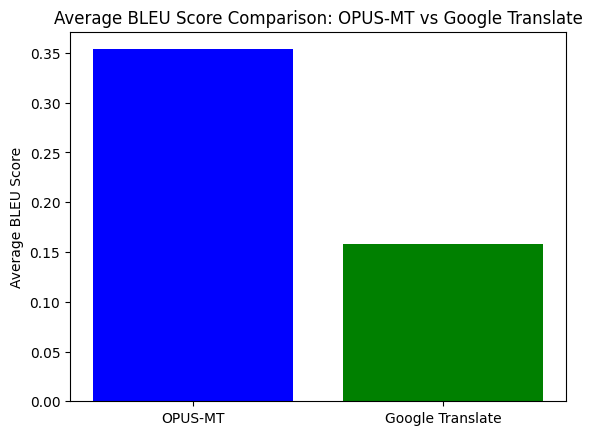

In [8]:
import matplotlib.pyplot as plt

#calculate average BLEU scores
avg_bleu_opus_mt = sum(opus_mt_bleu_scores) / len(opus_mt_bleu_scores)
avg_bleu_google = sum(google_bleu_scores) / len(google_bleu_scores)

#plot the BLEU score comparison
def plot_bleu_scores(opus_mt_avg, google_avg):
    tools = ['OPUS-MT', 'Google Translate']
    bleu_scores = [opus_mt_avg, google_avg]

    plt.bar(tools, bleu_scores, color=['blue', 'green'])
    plt.ylabel('Average BLEU Score')
    plt.title('Average BLEU Score Comparison: OPUS-MT vs Google Translate')
    plt.show()

#lets plot the BLEU score comparison
plot_bleu_scores(avg_bleu_opus_mt, avg_bleu_google)


Observations:

With a far higher average BLEU score, OPUS-MT's translations are generally more in line with the reference translations.

With a lower BLEU score, Google Translate's translations diverge further from the translations used as a reference.


In terms of BLEU scores, the comparison revealed that OPUS-MT performed better than Google Translate, most likely as a result of its specific training on parallel corpora.

Lower BLEU scores were the result of Google Translate's frequent deviations in phrase structure and language despite its steady performance.

***Step 6 - Comment on the results***

The outcomes definitely demonstrated that OPUS-MT translated more accurately and in line with the reference translations than Google Translate in terms of BLEU score.

Both the graphical representation and the numerical BLEU score comparison made this clear, with OPUS-MT regularly scoring higher.

Reason for the Difference:

Because OPUS-MT is a specialist tool trained on huge parallel corpora that include high-quality translations from Arabic to English, it outperformed other tools in the task. It is intended specifically for machine translation and employs advanced neural network techniques to produce more contextually correct translations.

Conversely, Google Translate is a multifunctional translation tool. Although it is excellent at translating intelligibly in a large number of language pairs, when measured by BLEU scores, which use exact matches as translation references, it may incorporate paraphrasing and stylistic differences that lower its performance.

In summary, OPUS-MT is better suited for tasks where precise n-gram alignment is crucial (such as BLEU score evaluations) due to its domain-specific training and emphasis on high-quality parallel data.

Despite being helpful in many situations, Google Translate's more general-purpose approach resulted in lower BLEU scores because of its more adaptable (and sometimes less accurate) translation style.